![title](https://image.ibb.co/erDntK/logo2018.png)

---




# Task 12 part 2/3 - Train CIFAR10 using GPU

In this second part of the assignment you will try to train a five layer CNN on CIFAR-10 dataset using GPU and feel the increased training speed compared to only using CPU

In this assignment you will also try to train the network using Data Augmentation


The goals of this assignment are as follows:

<pre>* train a five layer CNN using GPU from scratch
* train a five layer CNN using Data Augmentation 


---
---
#[Part 0] Import Libraries and Load Data

---
## 0 - Acceleration Setting

This time we will check the ability of TensorFlow if it is run with GPU acceleration.

For that, make sure that this Google Colab use **GPU** Runtime acceleration.
* Select the Runtime menu
* Change Runtime Type
* Choose **GPU**

<img src = "https://i.ibb.co/QX3Brf0/gpu.png" align = "center">



---
## 1 - Install TensorFlow 2

If Tensorflow 2 is not already installed, install it first

In [0]:
!pip install tensorflow-gpu -q

In [35]:
import tensorflow as tf
tf.__version__

'2.0.0'

**EXPECTED OUTPUT**:
<pre>
 '2.0.0'

In [36]:
import torch
torch.__version__

'1.3.0+cu100'

**EXPECTED OUTPUT**:
<pre>
 '1.3.0'

---
## 2 - Import Libraries
Import required libraries

In [37]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import pprint

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

%matplotlib inline
np.set_printoptions(precision=7)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Write down your Name and Student ID

In [0]:
## --- start your code here ----

NIM = 1301160098
Nama = "Panji Bagaskara"

## --- end your code here ----

---
## 3 - Load CIFAR-10

In [0]:
(X_train_ori, y_train), (X_test_ori, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---
## 4 - Split Validation Data

In [0]:
X_val_ori = X_train_ori[-10000:,:]
y_val     = y_train[-10000:]

X_train_ori = X_train_ori[:-10000, :]
y_train     = y_train[:-10000]

---
## 5 - Normalize and Reshape Data

In [41]:
X_train = X_train_ori.astype('float32')
X_val   = X_val_ori.astype('float32')
X_test  = X_test_ori.astype('float32')

mean_image = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_image = X_train.std(axis=(0, 1, 2), keepdims=True)

X_train = (X_train - mean_image) /std_image
X_val = (X_val - mean_image) /std_image
X_test = (X_test - mean_image) /std_image

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')


print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)

y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print('\ny_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

X_train.shape = (40000, 32, 32, 3)
X_val.shape   = (10000, 32, 32, 3)
X_test.shape  = (10000, 32, 32, 3)

y_train.shape = (40000,)
y_val.shape   = (10000,)
y_test.shape  = (10000,)


one hot the label

In [42]:
y_train_hot = to_categorical(y_train, 10)
y_val_hot   = to_categorical(y_val, 10)
y_test_hot  = to_categorical(y_test, 10)

print('y_train_hot.shape =',y_train_hot.shape)
print('y_val_hot.shape   =',y_val_hot.shape)
print('y_test_hot.shape  =',y_test_hot.shape)

y_train_hot.shape = (40000, 10)
y_val_hot.shape   = (10000, 10)
y_test_hot.shape  = (10000, 10)


---
## 6 - Helper Function

In [0]:
def plot_history(history):
  plt.rcParams['figure.figsize'] = [12, 4]
  plt.subplots_adjust(wspace=0.2)

  plt.subplot(121)
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'])

  plt.subplot(122)
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'])
  plt.show()

---
---
# [Part 1] Device Acceleration Checking

## 1 - GPU Availability Check

Next, let's check TensorFlow and PyTorch's ability to utilize GPU capabilities

**Because we set this Google Colab to run with GPU acceleration, Tensorflow will return the GPU device id**

**If we're using PyTorch to check the deivice, we can see the GPU name**

In [44]:
print('Using GPU:', tf.test.is_gpu_available())

if tf.test.is_gpu_available():
  print('GPU name :', tf.test.gpu_device_name())


Using GPU: True
GPU name : /device:GPU:0


**EXPECTED OUTPUT**:
<pre>
    Using GPU: True
    GPU name : /device:GPU:0

In [45]:
print('Using GPU:',torch.cuda.is_available())

if torch.cuda.is_available():
  print('GPU name :',torch.cuda.get_device_name(0))


Using GPU: True
GPU name : Tesla K80


**EXPECTED OUTPUT**:
<pre>
    Using GPU: True
    GPU name : Tesla K80

## 2 - TPU Availability Check

Then, let's check TensorFlow's ability to utilize TPU capabilities 

**Because we set this Google Colab to run with GPU acceleration, there will be no TPU acceleration that can be used**

In [46]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('Not connected to a TPU runtime')
  
else:
  
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  # for tf 2.x
  # tf.config.experimental_connect_to_host(tpu_address)
  # devices=tf.config.experimental_list_devices()
  
  # for tf 1.x  
  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:') 
  print(*devices, sep="\n")

Not connected to a TPU runtime


**EXPECTED OUTPUT**:
<pre>
Not connected to a TPU runtime

---
---
# [Part 2] Train 5-layer ConvNet

Now let's build and train our model



In [0]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D


---
## 1 - Model Builder

#### <font color='red'>**EXERCISE**: </font>
**Define a ConvNet Model as follow**

    * 32 @ Conv 3x3 using relu and padding same
    * 32 @ Conv 3x3 using relu and padding same
    * Max Pool
    * 64 @ Conv 3x3 using relu and padding same    
    * Max Pool
    * Flatten
    * Dense 200 using relu
    * Dense 10 using softmax
    
    then compile using categorical crossentropy and optimizer adam


In [0]:
def FiveConvNet(name):
  
  model = Sequential([

      Conv2D(32, (3,3), padding='SAME', activation='relu', input_shape=(32,32,3)), # conv
      Conv2D(32, (3,3), padding='SAME', activation='relu'), # conv
      MaxPool2D(), # pool
      Conv2D(64, (3,3), padding='SAME', activation='relu'), # conv
      MaxPool2D(), # pool
      Flatten(), # flatten
      Dense(200, activation='relu'), # dense
      Dense(10, activation='softmax')  # dense
      
  ], name = name) 
  
  model.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])
  
  return model

---
## 2 - Define Model

In [49]:
model = FiveConvNet('using_GPU')

model.summary()

Model: "using_GPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               81

**EXPECTED OUTPUT**:
<pre>
Model: "using_GPU"
conv2d (Conv2D)              (None, 32, 32, 32)        896       
...
dense_? (Dense)              (None, 10)                2010        

Total params: 850,050
Trainable params: 850,050
Non-trainable params: 0
_________________________________________________________________

---
## 3 - Train Model



#### <font color='red'>**EXERCISE**: </font>
**Train the model for 8 epochs using batch size 200**

**Don't forget to feed the validation data**


    

In [50]:
import time

num_epochs = 8
batch_size = 200

tic = time.time()

history = model.fit(X_train, y_train_hot, 
                    validation_data=(X_val, y_val_hot),
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    verbose=2)

toc = time.time()

print('\n\ntraining speed = %.2f seconds' % (toc-tic))
print('training speed = %.2f minutes' % ((toc-tic)/60))

Train on 40000 samples, validate on 10000 samples
Epoch 1/8
40000/40000 - 6s - loss: 1.4790 - accuracy: 0.4706 - val_loss: 1.2204 - val_accuracy: 0.5693
Epoch 2/8
40000/40000 - 5s - loss: 1.0448 - accuracy: 0.6314 - val_loss: 0.9871 - val_accuracy: 0.6582
Epoch 3/8
40000/40000 - 5s - loss: 0.8511 - accuracy: 0.7054 - val_loss: 0.9113 - val_accuracy: 0.6845
Epoch 4/8
40000/40000 - 5s - loss: 0.7198 - accuracy: 0.7484 - val_loss: 0.8591 - val_accuracy: 0.7053
Epoch 5/8
40000/40000 - 5s - loss: 0.6040 - accuracy: 0.7889 - val_loss: 0.8341 - val_accuracy: 0.7176
Epoch 6/8
40000/40000 - 5s - loss: 0.4971 - accuracy: 0.8259 - val_loss: 0.8590 - val_accuracy: 0.7197
Epoch 7/8
40000/40000 - 5s - loss: 0.3939 - accuracy: 0.8634 - val_loss: 0.9147 - val_accuracy: 0.7060
Epoch 8/8
40000/40000 - 5s - loss: 0.2947 - accuracy: 0.9005 - val_loss: 0.9886 - val_accuracy: 0.7099


training speed = 43.63 seconds
training speed = 0.73 minutes


**EXPECTED OUTPUT**:
<pre>
Your model should run in about 5 seconds per epoch
it should be about 30x faster than using CPU

---
## 4 - Visualize Training

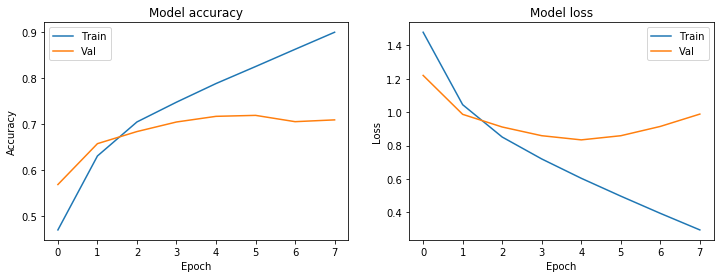

In [51]:
plot_history(history)

---
## 5 - Evaluate Model

In [52]:
val_scores   = model.evaluate(X_val, y_val_hot, verbose=2)
test_scores  = model.evaluate(X_test, y_test_hot, verbose=2)

10000/1 - 1s - loss: 1.3522 - accuracy: 0.7099
10000/1 - 1s - loss: 0.8210 - accuracy: 0.7089


**EXPECTED OUTPUT**:
<pre>
You should get around 72% accuracy on data test
tough the model is overfit

---
---
# [Part 3] Train ConvNet using Data Augmentation

In this part, we'll use the same 5 layer convnet model, but let's train it using Data Augmentation

We'll use the `ImageDataGenerator` function provided by `tf.keras`



---
## 1 - Define Model

Initiate new model

In [53]:
model_aug = FiveConvNet('Augmented')

model_aug.summary()

Model: "Augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               81

---
## 2 - Define Augmentation

Keras already provided a set of function to automatically perform Data Augmentation on the run while we train the data. This way, we don't need to manually  modify and store the data

you can read more detailed example [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

The first step is by defining what type of Augmentation we want to perform to our data

#### <font color='red'>**EXERCISE**: </font>
**Define your augmentation scheme**

    Common setting:
    * width and height shift 0.1 to 0.2
    * horizontal flip true
    * vertical flip false
    * zoom 0.1 to 0.2
    * rotation


    

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    
    rotation_range=0,
    
    width_shift_range=[0.1,0.2],
    
    height_shift_range=[0.1,0.2],
    
    brightness_range=[0.0, 1.0],
    
    shear_range=0.0,
    
    zoom_range=[0.1,0.2],
    
    channel_shift_range=0.0,
    
    horizontal_flip=True,
    
    vertical_flip=False,
    
    rescale=None,
    
)


Prepare the data generator to fit the train data

In [0]:
datagen.fit(X_train)

---
## 3 - Train Model

To train the model using Data Augmentation, we're not going to use `.fit()` function, 

but instead, we use `.fit_generator()` function

when passing the data train to the `.fit_generator()`  function, we'll use `datagen.flow()` to perform the augmentation on the run

the use is as follow

```python
augmented = datagen.flow(data, target, batch_size=??)

history = model.fit_generator( augmented, validation=??, epoch=??)

```

#### <font color='red'>**EXERCISE**: </font>
**Train the model for 8 epochs using batch size 200**

**Don't forget to feed the validation data**


    

In [56]:
import time

num_epochs = 8
batch_size = 200

tic = time.time()

# call datagen.flow() function with input X_train, y_train_hot, and batch_size
augmented_train = datagen.flow(
    X_train, y_train_hot, batch_size
)


# call model_aug.fit_generator() function with input augmented_train,
# validation_data = (X_val, y_val_hot), and epoch
history_aug = model_aug.fit_generator(
    augmented_train,
    validation_data=(X_val, y_val_hot),
    epochs=num_epochs, 
    verbose=2)

toc = time.time()

print('\n\ntraining speed = %.2f seconds' % (toc-tic))
print('training speed = %.2f minutes' % ((toc-tic)/60))

Epoch 1/8
200/200 - 46s - loss: 2.6749 - accuracy: 0.1850 - val_loss: 2.2978 - val_accuracy: 0.1163
Epoch 2/8
200/200 - 45s - loss: 2.1123 - accuracy: 0.2107 - val_loss: 2.2050 - val_accuracy: 0.1550
Epoch 3/8
200/200 - 45s - loss: 2.0788 - accuracy: 0.2251 - val_loss: 2.1628 - val_accuracy: 0.1829
Epoch 4/8
200/200 - 45s - loss: 2.0584 - accuracy: 0.2319 - val_loss: 2.1408 - val_accuracy: 0.1913
Epoch 5/8
200/200 - 45s - loss: 2.0457 - accuracy: 0.2374 - val_loss: 2.1331 - val_accuracy: 0.2017
Epoch 6/8
200/200 - 45s - loss: 2.0387 - accuracy: 0.2376 - val_loss: 2.1655 - val_accuracy: 0.1749
Epoch 7/8
200/200 - 45s - loss: 2.0249 - accuracy: 0.2442 - val_loss: 2.1894 - val_accuracy: 0.1710
Epoch 8/8
200/200 - 45s - loss: 2.0254 - accuracy: 0.2459 - val_loss: 2.2322 - val_accuracy: 0.1486


training speed = 359.60 seconds
training speed = 5.99 minutes


**EXPECTED OUTPUT**:
<pre>
Your model should run in about 30-50 seconds per epoch
depending on your Augmentation scheme

---
## 4 - Visualize Training

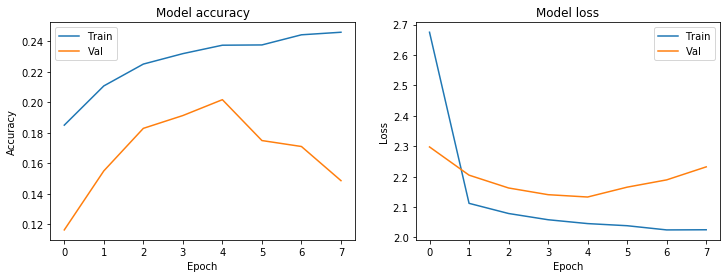

In [57]:
plot_history(history_aug)

---
## 5 - Evaluate Model

In [58]:
val_scores   = model_aug.evaluate(X_val, y_val_hot, verbose=2)
test_scores  = model_aug.evaluate(X_test, y_test_hot, verbose=2)

10000/1 - 2s - loss: 2.1935 - accuracy: 0.1486
10000/1 - 2s - loss: 2.2667 - accuracy: 0.1568


**EXPECTED OUTPUT**:
<pre>
You should get around 76% accuracy on data test

You should also see that using Data Augmentation prevent Overfitting

---
---
# [Part 4] Train CIFAR10 using VGG

Our 5-layer ConvNet already runs fast with 5 seconds per epoch

Not much from here that can be accelerated anymore

So instead, let's define a bigger model using VGG16 so we can later compare it with TPU accelerated computation



---
## 1 - Model Builder

Load empty VGG16, cut it up to the 4th block, then add a Global Average Pooling and a couple of Dense Layer

#### <font color='red'>**EXERCISE**: </font>
**Define a ConvNet Model as follow**

    * vgg16 model with weights=None, include_top=False, and input_shape=(32,32,3)
    * get layer 'block4_conv3' output
    * GlobalAveragePooling2D
    * Dense 200 using relu
    * Dense 10 using softmax
    
    use Functional API,
    then compile using categorical crossentropy and optimizer adam


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

def CifarVGG(name):
  
  # load empty vgg16 no top with input (32,32,3)
  model = VGG16(weights=None, include_top=False, input_shape=(32, 32, 3))

  # get 'block4_conv3' output
  x = model.get_layer('block4_conv3').output
  
  # global average pooling
  x = GlobalAveragePooling2D()(x)

  # dense 200
  x = Dense(200, activation='relu')(x)

  # dense 10
  prediction = Dense(10, activation='softmax')(x)
  
  # instantiate model
  myModel = Model(inputs=model.input, outputs=prediction, name=name)

  myModel.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])
  
  return myModel
  

---
## 2 - Define Model

In [60]:
model = CifarVGG('VGG_using_GPU')

model.summary()

Model: "VGG_using_GPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)       

**EXPECTED OUTPUT**:
<pre>
Model: "VGG_using_GPU"
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
...
dense_? (Dense)              (None, 200)               102600    
prediction (Dense)           (None, 10)                2010      

Total params: 7,739,874
Trainable params: 7,739,874
Non-trainable params: 0
_________________________________________________________________

---
## 3 - Train Model

Now train the model for 10 epoch

For greater comparison, we'll use batch size of 1000

But this time, notice that we're not passing validation set


In [61]:
import time

num_epochs = 10
batch_size = 1000

tic = time.time()

history = model.fit(X_train, y_train_hot, 
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    verbose=2)

toc = time.time()

print('\n\ntraining speed = %.2f seconds' % (toc-tic))
print('training speed = %.2f minutes' % ((toc-tic)/60))

Train on 40000 samples
Epoch 1/10
40000/40000 - 22s - loss: 2.1728 - accuracy: 0.1629
Epoch 2/10
40000/40000 - 20s - loss: 1.8708 - accuracy: 0.2815
Epoch 3/10
40000/40000 - 20s - loss: 1.6179 - accuracy: 0.3808
Epoch 4/10
40000/40000 - 20s - loss: 1.4695 - accuracy: 0.4349
Epoch 5/10
40000/40000 - 21s - loss: 1.3223 - accuracy: 0.5033
Epoch 6/10
40000/40000 - 20s - loss: 1.1446 - accuracy: 0.5813
Epoch 7/10
40000/40000 - 21s - loss: 0.9942 - accuracy: 0.6403
Epoch 8/10
40000/40000 - 21s - loss: 0.8457 - accuracy: 0.6972
Epoch 9/10
40000/40000 - 21s - loss: 0.7932 - accuracy: 0.7163
Epoch 10/10
40000/40000 - 21s - loss: 0.6827 - accuracy: 0.7588


training speed = 206.45 seconds
training speed = 3.44 minutes


**EXPECTED OUTPUT**:
<pre>
Your model should run in about 20 seconds per epoch

---
## 4 - Evaluate Model

In [62]:
val_scores   = model.evaluate(X_val, y_val_hot, verbose=2)
test_scores  = model.evaluate(X_test, y_test_hot, verbose=2)

10000/1 - 5s - loss: 1.0124 - accuracy: 0.7231
10000/1 - 4s - loss: 0.7180 - accuracy: 0.7157


**EXPECTED OUTPUT**:
<pre>
You should get around 70% accuracy on data test



---

# Congratulation, You've Completed Exercise 12 part 2/3

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2019 - ADF</a> </p>

![footer](https://image.ibb.co/hAHDYK/footer2018.png)